# Hierarchical Forecasting   
  
__What It Is__   
	- Hierarchical forecasting aggregates data at higher levels (e.g., brand level or total sales) to compensate for sparsity at lower levels (e.g., brand + family).   
	- Predictions are made at the higher levels and disaggregated down to smaller groups (e.g., brand-family) using proportions.   
  
Steps to Implement   
1.	Aggregate to Higher Levels:   
	- Aggregate sparse brand-family data up to broader levels:   
	- Brand level: brand_total_sales  
	- Family level: family_total_sales  
	- Overall total: global_total_sales  
	- Use the aggregated time series to train the model.  
2.	Forecast at Higher Levels:   
	- Predict sales at the aggregated levels using richer historical data.  
3.	Disaggregate Forecasts:  
	- Split the higher-level forecasts back down to the brand-family level using historical proportions. For example:
$\text{brand\_family\_forecast} = \text{brand\_forecast} \times \frac{\text{brand\_family\_sales}}{\text{brand\_total\_sales}}$  
4.	Smooth Proportions for Stability:  
	- Use smoothed historical proportions (e.g., rolling averages) to prevent overfitting to noisy historical proportions.  

---

In this case we will apply 2 classical forecasting models:  
	- Exponential smoothing  
	- Sarima  
to the global time series of revenues.  

The idea is that, while aggregating at the global level, seasonalities becomes visible and the variance gets smaller. This is good while predicting over a large forecastiong horizon.  
And this is also why it's particularly important to remove the big outliers.


In [1]:
import pandas as pd
import utils.utils_models as utils_models

import utils.utils_preprocessing as utils_preprocessing
import utils.utils_features as utils_features

In [2]:
df_sales = pd.read_parquet("data/sales.parquet")
df_products = pd.read_parquet("data/products.parquet")
df = df_sales.merge(df_products, on="product_id")

In [3]:
df = utils_preprocessing.set_types(df)
df = utils_preprocessing.filter_dates(df, date="2024-09-01")
df = utils_preprocessing.remove_outliers(df, window_size=5, threshold=2)

df_monthly = utils_preprocessing.aggregate_data(
    df, 
    frequency="ME"
    )
df_monthly = utils_preprocessing.fill_in_missing_dates(
    df_monthly, 
    group_col=["brand", "family"], 
    date_col="date", 
    freq="ME"
    )
df_monthly = utils_features.features_time_related(
    df_monthly, 
    frequency='ME'
    )

In [10]:
train_end_date = df_monthly['date'].max() - pd.DateOffset(months=12)

train_data = df_monthly[df_monthly['date'] <= train_end_date]
test_data = df_monthly[df_monthly['date'] > train_end_date]
X_train, X_test, y_train, y_test = utils_preprocessing.train_test_split(df_monthly, forecasting_horizon=12, target_col="total_revenue")

## Exponential smoothing

/Users/matteogiaretti/Python/use_case_deporvillage/.venv/lib/python3.13/site-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency ME will be used.
  self._init_dates(dates, freq)
/Users/matteogiaretti/Python/use_case_deporvillage/.venv/lib/python3.13/site-packages/statsmodels/tsa/holtwinters/model.py:918: ConvergenceWarning: Optimization failed to converge. Check mle_retvals.
  warnings.warn(


,date,forecast_total_revenue,month,total_revenue_agg
0,2023-09-30,78608.614875,9,85721.351562
1,2023-10-31,78019.224130,10,115597.914062
2,2023-11-30,130788.124121,11,134536.625000
3,2023-12-31,140434.300155,12,152409.718750
4,2024-01-31,139505.358876,1,147016.968750
5,2024-02-29,105427.822919,2,114546.195312
6,2024-03-31,124854.841164,3,147784.343750
7,2024-04-30,126419.406580,4,148627.375000
8,2024-05-31,123975.022648,5,144400.046875
9,2024-06-30,105854.186693,6,124878.882812


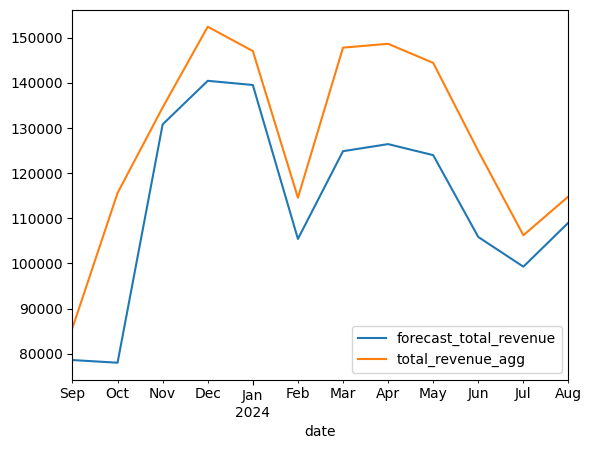

In [11]:
hyperparameters = {
    "trend": "mul",           
    "seasonal": "mul",       
    "seasonal_periods": 12, 
    "steps_ahead": 12, 
}

exp_smoothing_model = utils_models.HierarchicalModel(forecasting_model="ExponentialSmoothing", hyperparameters=hyperparameters)
exp_smoothing_model.train(X_train=train_data, y_train=None)
exp_smoothing_model.evaluate_agg_forecast(test_data)

In [12]:
df_predictions = exp_smoothing_model.predict(X_test)
df_predictions = pd.merge(test_data[['date', 'brand', 'family', 'total_revenue']], df_predictions, on=['date', 'brand', 'family'], how='left')
df_predictions = df_predictions.rename(columns={'total_revenue': 'y', 'forecast_revenue': 'y_pred'})

In [13]:
exp_smoothing_model.evaluate(df_predictions, metric='RMSE')
exp_smoothing_model.evaluate(df_predictions, metric='MAPE')

Average RMSE from cross-validation: 15403.0700
Average MAPE from cross-validation: 0.8700


0.87

## Sarima

/Users/matteogiaretti/Python/use_case_deporvillage/.venv/lib/python3.13/site-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency ME will be used.
  self._init_dates(dates, freq)
/Users/matteogiaretti/Python/use_case_deporvillage/.venv/lib/python3.13/site-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency ME will be used.
  self._init_dates(dates, freq)
/Users/matteogiaretti/Python/use_case_deporvillage/.venv/lib/python3.13/site-packages/statsmodels/tsa/statespace/sarimax.py:866: UserWarning: Too few observations to estimate starting parameters for seasonal ARMA. All parameters except for variances will be set to zeros.
  warn('Too few observations to estimate starting parameters%s.'


,date,forecast_total_revenue,month,total_revenue_agg
0,2023-09-30,85800.636682,9,85721.351562
1,2023-10-31,80736.667281,10,115597.914062
2,2023-11-30,134920.082573,11,134536.625000
3,2023-12-31,134725.739416,12,152409.718750
4,2024-01-31,121016.222987,1,147016.968750
5,2024-02-29,85872.335154,2,114546.195312
6,2024-03-31,93615.090762,3,147784.343750
7,2024-04-30,90877.529741,4,148627.375000
8,2024-05-31,90764.299223,5,144400.046875
9,2024-06-30,71237.853551,6,124878.882812


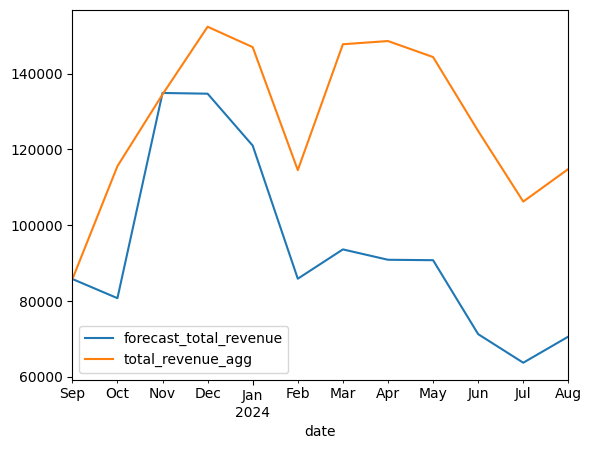

In [14]:
# Predict with aggregated data (SARIMA)

hyperparameters = {
    "order": (1, 1, 1),            
    "seasonal_order": (1, 1, 1, 12),  
    "steps_ahead": 12       
}
sarima_model = utils_models.HierarchicalModel(forecasting_model="Sarima", hyperparameters=hyperparameters)
sarima_model.train(X_train=train_data, y_train=None)
sarima_model.evaluate_agg_forecast(test_data)

In [15]:
df_predictions = sarima_model.predict(X_test)
df_predictions = pd.merge(test_data[['date', 'brand', 'family', 'total_revenue']], df_predictions, on=['date', 'brand', 'family'], how='left')
df_predictions = df_predictions.rename(columns={'total_revenue': 'y', 'forecast_revenue': 'y_pred'})
sarima_model.evaluate(df_predictions, metric='RMSE')
sarima_model.evaluate(df_predictions, metric='MAPE')

Average RMSE from cross-validation: 18318.2500
Average MAPE from cross-validation: 0.7700


0.77

<Axes: >

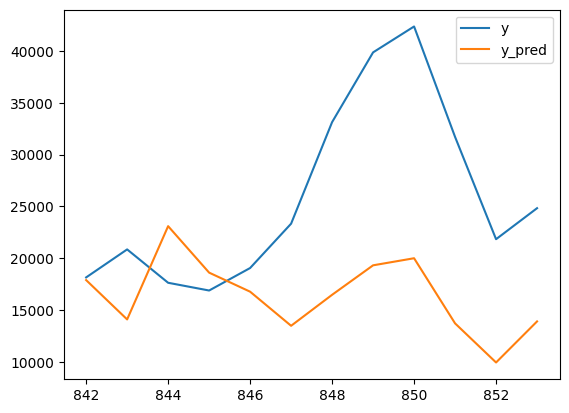

In [20]:
family = "Zapatillas Urban"
brand = "adidas"
df_predictions[(df_predictions["family"] == family) & (df_predictions["brand"] == brand)][["y", "y_pred"]].plot()